# G$^2$Pnet: The Grassmanian Gaussian Process Network
We check the implementation of G2PnetSolver (ver 6.) with conjugate gradient descent class in ../src/

Created by Tianpei Xie, 04/13/2016

Last Edit 04/13/2016

In [1]:
%reset
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import seaborn as sns
import pandas as pd
from sklearn.cross_validation import train_test_split
from sklearn.metrics.pairwise import rbf_kernel, pairwise_kernels
import GPy
import GPy.util as gutil

%matplotlib inline 
plt.close('all')

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


/Applications/anaconda/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [2]:
Ifsavefig =  True
Ifsavedata = False #True
trial = 7

In [3]:
G=nx.read_adjlist("../data/04_01_2016_experiment8.adjlist")

size = 40
color_map = {0:'r', 1:'c', 2:'y'}
#center = np.zeros(2)
#center[1] = 1
center = None

n = 40
m = 0
G0= nx.barbell_graph(n,m) 
#generate the bar-bell graph, which consists of two fully connected component and a path connecting them 

label0 = np.zeros([2*n,1])
label0[n:2*n] = np.ones([n,1])
#### labeling of the cluster
for node in G0.nodes():
    G0.node[node]['category'] = int(label0[node,0])

In [4]:
data_df = pd.read_csv("../data/04_01_2016_experiment8_X.csv", index_col = 'ID')
spectral_df = pd.read_csv("../data/04_01_2016_experiment8_U.csv", index_col ='ID')
U_init_pd = pd.read_csv("../data/04_01_16_8_U_init.csv", index_col = 0)

In [5]:
X = data_df.loc[:,['0_cos','1_cos']].values
U = spectral_df.loc[:,['PX','PY']].values
labels = data_df.loc[:,'LABEL'].values
U_init = U_init_pd.loc[:,['0','1']].values

In [6]:
nsample, ndim = X.shape
_ , ndim_latent = U.shape

In [7]:
import sys
import os
dirorg = os.path.dirname(os.getcwd())
sys.path.insert(0, dirorg+"/src/")

In [8]:
import G2PnetSolver_v6 #G2PnetSolver_v2
#from imp import reload
#reload(G2PnetSolver_v2)

In [9]:
from G2PnetSolver_v6 import  G2PnetSolver as Solver
from G2PnetSolver_v6 import  Grassmann_update, check_step

In [10]:
choice = "near"
IfGen = False

In [68]:
add_reg = True
lambda_array = np.array([1]) #10, 1, 0.001
eta = 2e-4 #0.0001
max_iters = 600
kern_array = [GPy.kern.RBF(2)+ GPy.kern.White(2) for i in np.arange(len(lambda_array))]
kern_grass_array = [GPy.kern.RBF(2)+ GPy.kern.White(2)for i in np.arange(len(lambda_array))]
kern_conjugate_grass_array = [GPy.kern.RBF(2)+ GPy.kern.White(2) for i in np.arange(len(lambda_array))]
solver_array = []
hist_nll_eu_array = []
hist_nll_grass_array = []
hist_nll_conjugate_grass_array = []
hist_Hsig_array = []
hist_Hsig_conjugate_array = []
hist_Gnorm_array = []
hist_Gnorm_conjugate_array = []
hist_gamma_array = []
hist_deltaG_array = []
hist_condK_array = []
hist_condK_grass_array = []
hist_condK_conjugate_array = []
hist_cond2K_array = []
hist_cond2K_grass_array = []
hist_cond2K_conjugate_array = []

In [69]:
lambda_var = lambda_array[0]
solver3 = Solver(X=X, U=U_init, kernel=kern_conjugate_grass_array[0], U_ref = U, add_reg = add_reg, lambda_var = lambda_var, eta=eta)

kernel initialization ...
Running L-BFGS-B (Scipy implementation) Code:
  runtime   i     f              |g|        
    00s04  010   1.516748e+02   4.072272e+01 
    00s07  018   1.509592e+02   2.323557e-07 
    00s08  020   1.509592e+02   2.859615e-09 
Runtime:     00s08
Optimization status: Converged

negative log-likelihood compute


In [70]:
solver3.kern

sum.,Value,Constraint,Prior,Tied to
rbf.variance,1.13790264085,+ve,,
rbf.lengthscale,0.128641637734,+ve,,
white.variance,0.123873509289,+ve,,


In [75]:
solver3.kern_param_names

['rbf.variance', 'rbf.lengthscale', 'white.variance']

In [77]:
solver3.kern.rbf.lengthscale.values

array([ 0.12864164])

In [78]:
solver3.kern.rbf.variance.values

array([ 1.13790264])

In [79]:
solver3.kern.white.variance.values    

array([ 0.12387351])

In [81]:
solver3.kern.param_array[:] 

array([ 1.13790264,  0.12864164,  0.12387351])

In [82]:
solver3.kern.param_array[:] = [1,1,1]

In [83]:
solver3.kern

sum.,Value,Constraint,Prior,Tied to
rbf.variance,1.0,+ve,,
rbf.lengthscale,1.0,+ve,,
white.variance,1.0,+ve,,


In [84]:
solver3.kern.name

'sum'

In [106]:
model = GPy.models.GPRegression(X= U_init, Y = X, kernel = GPy.kern.RBF(2)+ GPy.kern.White(2) , noise_var = 1)

In [109]:
model.kern.white.constrain_bounded(0.01, 1.0, warning=False)
model.kern

sum.,Value,Constraint,Prior,Tied to
rbf.variance,1.0,+ve,,
rbf.lengthscale,1.0,+ve,,
white.variance,1.0,"0.01,1.0",,


In [ ]:
model['.*.white.variance'].constrain_bounded

In [ ]:
('.*.white.variance', lower=0.25, upper=1.0 ) 

In [87]:
kern4 = GPy.kern.White(2)
kern4.rbf

AttributeError: 'White' object has no attribute 'rbf'

In [71]:
Kernel = solver3.kern.K(U_init)

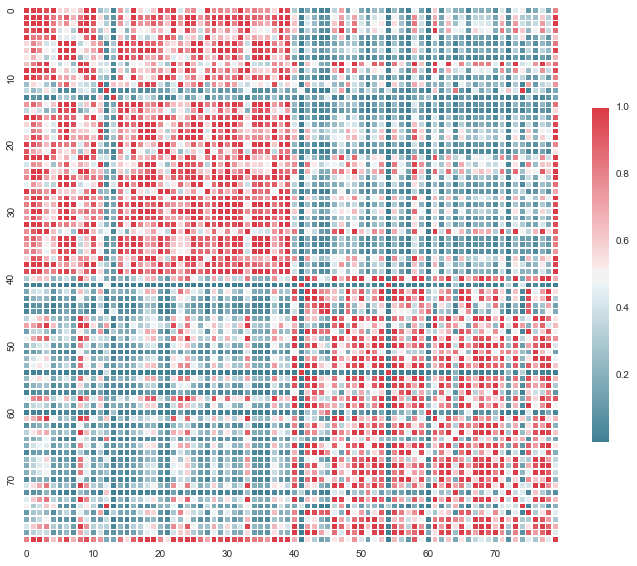

In [72]:
fig= plt.figure(5)
fig.set_size_inches(12.0, 12.0)
sns.set(style="white")

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

ax = plt.axes()
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(Kernel, cmap=cmap, vmax=1, #.3,
            square=True, xticklabels=10, yticklabels=10,
            linewidths=.8, cbar_kws={"shrink": .5}, ax=ax)
#ax.set_title('sigmoid kernel', fontsize = 20)
plt.show()
if Ifsavefig:
    fig.savefig("../figures/rbf_kernel" + str(trial) +  "_04_13_16.eps")

In [73]:
np.log10(np.linalg.cond(Kernel))

2.528993116879624

In [74]:
np.linalg.matrix_rank(Kernel)

80

In [48]:
Kernel.shape

(80, 80)

In [55]:
Kernel2 = Kernel + np.eye(Kernel.shape[0])

In [56]:
np.log10(np.linalg.cond(Kernel2))

1.6309660013123666

In [57]:
np.linalg.matrix_rank(Kernel2)

80

In [67]:
kern2 = solver3.kern+ GPy.kern.White(2)
Kernel3 = kern2.K(U_init)
np.linalg.matrix_rank(Kernel3)

80

In [59]:
kern2

sum.,Value,Constraint,Prior,Tied to
rbf.variance,1.13790706758,+ve,,
rbf.lengthscale,0.128641762371,+ve,,
white.variance,1.0,+ve,,


In [62]:
kern2.white.K(U_init, U_init)

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

In [66]:
kern3 = GPy.kern.White(2, variance=2.0)
kern3.K(U_init)

array([[ 2.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  2.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  2., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  2.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  2.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  2.]])

In [60]:
np.diag(Kernel3)

array([ 1.13790707,  1.13790707,  1.13790707,  1.13790707,  1.13790707,
        1.13790707,  1.13790707,  1.13790707,  1.13790707,  1.13790707,
        1.13790707,  1.13790707,  1.13790707,  1.13790707,  1.13790707,
        1.13790707,  1.13790707,  1.13790707,  1.13790707,  1.13790707,
        1.13790707,  1.13790707,  1.13790707,  1.13790707,  1.13790707,
        1.13790707,  1.13790707,  1.13790707,  1.13790707,  1.13790707,
        1.13790707,  1.13790707,  1.13790707,  1.13790707,  1.13790707,
        1.13790707,  1.13790707,  1.13790707,  1.13790707,  1.13790707,
        1.13790707,  1.13790707,  1.13790707,  1.13790707,  1.13790707,
        1.13790707,  1.13790707,  1.13790707,  1.13790707,  1.13790707,
        1.13790707,  1.13790707,  1.13790707,  1.13790707,  1.13790707,
        1.13790707,  1.13790707,  1.13790707,  1.13790707,  1.13790707,
        1.13790707,  1.13790707,  1.13790707,  1.13790707,  1.13790707,
        1.13790707,  1.13790707,  1.13790707,  1.13790707,  1.13

kernel initialization ...
negative log-likelihood compute
[step   0] neg-log-likelihood -776.545232 stepsize 0.0002
The gradient of L w.r.t. U not been computed. Just compute it anyway.
The gradient of L w.r.t K not been computed. Just compute it anyway.
The gradient of K w.r.t. U not been computed. Just compute it anyway
[step   1] neg-log-likelihood -785.490132 stepsize 0.0002
[step   2] neg-log-likelihood -795.675150 stepsize 0.0002
[step   3] neg-log-likelihood -818.614052 stepsize 0.0002
[step   4] neg-log-likelihood -828.489161 stepsize 0.0002
[step   5] neg-log-likelihood -821.476631 stepsize 0.0002
[step   6] neg-log-likelihood -808.554953 stepsize 0.0002
[step   7] neg-log-likelihood -790.665666 stepsize 0.0002
[step   8] neg-log-likelihood -772.256565 stepsize 0.0002
[step   9] neg-log-likelihood -752.663377 stepsize 0.0002
[step  10] neg-log-likelihood -737.297366 stepsize 0.0002
[step  11] neg-log-likelihood -725.493842 stepsize 0.0002
[step  12] neg-log-likelihood -723.679

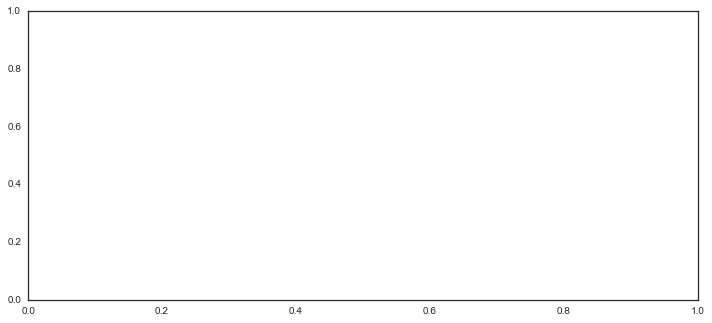

In [14]:
fig= plt.figure(1)
fig.set_size_inches(12.0, 30.0)
plt.style.use('seaborn-white')

for i, lambda_var in enumerate(lambda_array): 
    ax = plt.subplot(5,1,i+1)
    solver = Solver(X=X, U=U_init, kernel=kern_array[i], U_ref= U, add_reg = add_reg, lambda_var = lambda_var, eta=eta)
    hist_nll_eu, hist_eta, hist_kern_eu = solver.optimize(max_iters = max_iters)
    solver_array.append(solver)
    hist_cond2K_array.append(solver.hist_cond_dK)
    hist_condK_array.append(solver.hist_cond_K)
    hist_nll_eu_array.append(hist_nll_eu)
    
    
    solver2 = Solver(X=X, U=U_init, kernel=kern_grass_array[i], U_ref = U, add_reg = add_reg, lambda_var = lambda_var, eta=eta)
    hist_nll_grass, hist_eta, hist_kern_grass = solver2.optimize(max_iters = max_iters, optimizor = "grad_descent_grass")
    hist_Hsig_array.append(solver2.hist_Hsig)
    hist_Gnorm_array.append(solver2.hist_G_norm)
    hist_cond2K_grass_array.append(solver2.hist_cond_dK)
    hist_condK_grass_array.append(solver2.hist_cond_K)
    
    solver_array.append(solver2)
    hist_nll_grass_array.append(hist_nll_grass)
        
    solver3 = Solver(X=X, U=U_init, kernel=kern_conjugate_grass_array[i], U_ref = U, add_reg = add_reg, lambda_var = lambda_var, eta=eta)
    hist_nll_grass2, hist_eta2, hist_kern_grass2 = solver3.optimize(max_iters = max_iters, optimizor = "conjugate_grad_grass")
    hist_Hsig_conjugate_array.append(solver3.hist_Hsig)    
    hist_Gnorm_conjugate_array.append(solver3.hist_G_norm)   
    hist_deltaG_array.append(solver3.hist_delta_G)
    hist_gamma_array.append(solver3.hist_gamma)
    hist_cond2K_conjugate_array.append(solver3.hist_cond_dK)
    hist_condK_conjugate_array.append(solver3.hist_cond_K)

    solver_array.append(solver3)
    hist_nll_conjugate_grass_array.append(hist_nll_grass2)
    
    %xdel solver
    %xdel solver2
    %xdel solver3

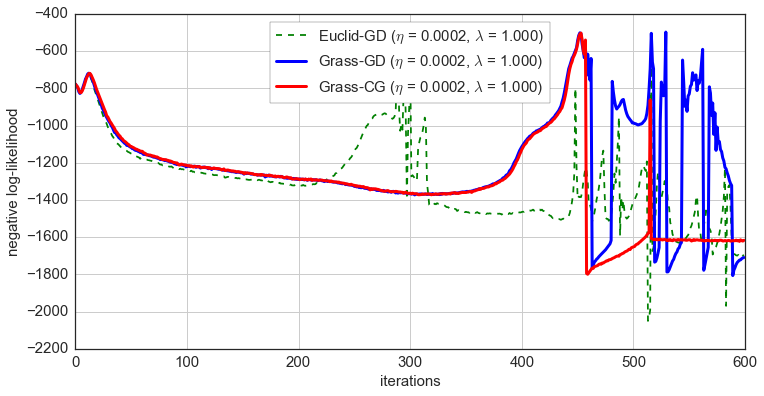

In [15]:
fig= plt.figure(1)
fig.set_size_inches(12.0, 6.0*len(lambda_array))
plt.style.use('seaborn-white')

for i in np.arange(len(lambda_array)):
    ax = plt.subplot(len(lambda_array),1,i+1)
    h1, = plt.plot(np.arange(max_iters), hist_nll_eu_array[i], '--g')
    h2, = plt.plot(np.arange(max_iters), hist_nll_grass_array[i], '-b', linewidth=3.0)
    h3, = plt.plot(np.arange(max_iters), hist_nll_conjugate_grass_array[i], '-r', linewidth=3.0)

    if add_reg:
         ax.legend([h1, h2, h3], [r"Euclid-GD ($\eta$ = {0:5.4f}, $\lambda$ = {1:5.3f})".format(eta, lambda_array[i]), \
                                  r"Grass-GD ($\eta$ = {0:5.4f}, $\lambda$ = {1:5.3f})".format(eta, lambda_array[i]), \
                                  r"Grass-CG ($\eta$ = {0:5.4f}, $\lambda$ = {1:5.3f})".format(eta, lambda_array[i])], \
                             fontsize = 15, loc='upper center', frameon=True)
        #ax.legend([h3], [r"Conjugate Grassmann ($\eta$ = {0:6.5f}, $\lambda$ = {1:5.3f})".format(eta, lambda_array[i])], \
        #                     fontsize = 15, loc='upper center', frameon=True)
    else:    
        ax.legend([h1, h2, h3], [r"Euclid-GD ($\eta$ = {0:6.5f})".format(eta), r"Grass-GD ($\eta$ = {0:6.5f})".format(eta), \
                                 r"Grass-CG ($\eta$ = {0:6.5f})".format(eta)], \
                             fontsize = 15, loc='upper center', frameon=True)
    plt.grid(1)
    plt.ylabel('negative log-likelihood', fontsize = 15)
    plt.xlabel('iterations', fontsize = 15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
plt.show    
if Ifsavefig:
    file_org = "../figures/04_13_16_" + str(trial) + "_"
    file_tail = "_nll_iters_GrassCG_GD_EuGD.eps"
    if choice == "random":
        file_comment = "rand"
    elif choice == "near":
        file_comment = "near"
        
    if add_reg:
        file_comment = file_comment +'Reg'
        
    fig.savefig(file_org + file_comment + file_tail )  

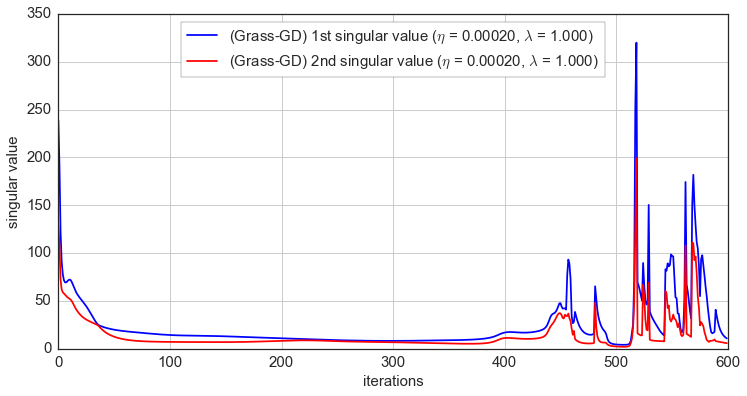

In [16]:
fig= plt.figure(2)
fig.set_size_inches(12.0, 6.0*len(lambda_array))
plt.style.use('seaborn-white')

for i in np.arange(len(lambda_array)):
    ax = plt.subplot(len(lambda_array),1,i+1)
    h1, = plt.plot(np.arange(max_iters), hist_Hsig_array[i][:,0], 'b')
    h2, = plt.plot(np.arange(max_iters), hist_Hsig_array[i][:,1], 'r')
    if add_reg:
        ax.legend([h1, h2], [r"(Grass-GD) 1st singular value ($\eta$ = {0:6.5f}, $\lambda$ = {1:5.3f})".format(eta, lambda_array[i]), \
                             r"(Grass-GD) 2nd singular value ($\eta$ = {0:6.5f}, $\lambda$ = {1:5.3f})".format(eta, lambda_array[i])], \
                             fontsize = 15, loc='upper center', frameon=True)
    else:    
        ax.legend([h1, h2], [r"1st singular value ($\eta$ = {0:6.5f})".format(eta), r"2nd singular value ($\eta$ = {0:5.4f})".format(eta)], \
                             fontsize = 15, loc='upper center', frameon=True)
    plt.grid(1)
    plt.ylabel('singular value', fontsize = 15)
    plt.xlabel('iterations', fontsize = 15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
plt.show    
if Ifsavefig:
    file_org = "../figures/04_13_16_" + str(trial) + "_"
    file_tail = "_sig_iters_Grass_GD.eps"
    if choice == "random":
        file_comment = "rand"
    elif choice == "near":
        file_comment = "near"
        
    if add_reg:
        file_comment = file_comment +'Reg'
        
    fig.savefig(file_org + file_comment + file_tail )  

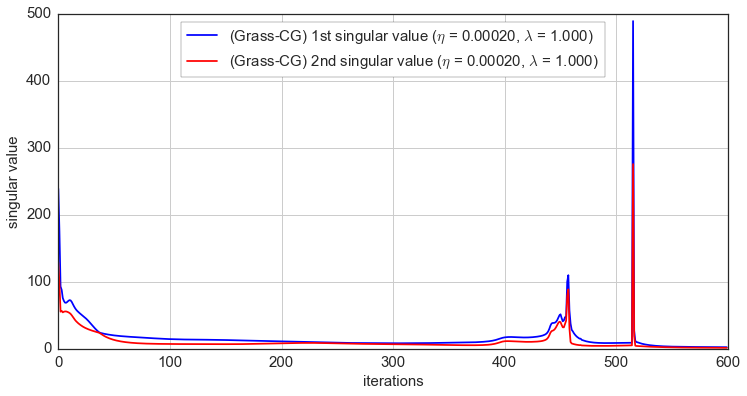

In [17]:
fig= plt.figure(3)
fig.set_size_inches(12.0, 6.0*len(lambda_array))
plt.style.use('seaborn-white')

for i in np.arange(len(lambda_array)):
    ax = plt.subplot(len(lambda_array),1,i+1)
    h1, = plt.plot(np.arange(max_iters), hist_Hsig_conjugate_array[i][:,0], 'b')
    h2, = plt.plot(np.arange(max_iters), hist_Hsig_conjugate_array[i][:,1], 'r')
    if add_reg:
        ax.legend([h1, h2], [r"(Grass-CG) 1st singular value ($\eta$ = {0:6.5f}, $\lambda$ = {1:5.3f})".format(eta, lambda_array[i]), \
                             r"(Grass-CG) 2nd singular value ($\eta$ = {0:6.5f}, $\lambda$ = {1:5.3f})".format(eta, lambda_array[i])], \
                             fontsize = 15, loc='upper center', frameon=True)
    else:    
        ax.legend([h1, h2], [r"1st singular value ($\eta$ = {0:6.5f})".format(eta), r"2nd singular value ($\eta$ = {0:5.4f})".format(eta)], \
                             fontsize = 15, loc='upper center', frameon=True)
    plt.grid(1)
    plt.ylabel('singular value', fontsize = 15)
    plt.xlabel('iterations', fontsize = 15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
plt.show    
if Ifsavefig:
    file_org = "../figures/04_13_16_" + str(trial) + "_"
    file_tail = "_sig_iters_Grass_CG.eps"
    if choice == "random":
        file_comment = "rand"
    elif choice == "near":
        file_comment = "near"
        
    if add_reg:
        file_comment = file_comment +'Reg'
        
    fig.savefig(file_org + file_comment + file_tail )  

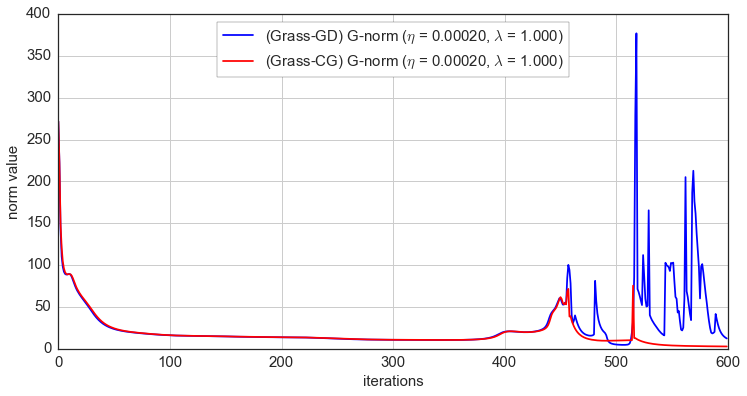

In [18]:
fig= plt.figure(4)
fig.set_size_inches(12.0, 6.0*len(lambda_array))
plt.style.use('seaborn-white')

for i in np.arange(len(lambda_array)):
    ax = plt.subplot(len(lambda_array),1,i+1)
    h1, = plt.plot(np.arange(max_iters), hist_Gnorm_array[i], 'b')
    h2, = plt.plot(np.arange(max_iters), hist_Gnorm_conjugate_array[i], 'r')
    if add_reg:
        ax.legend([h1, h2], [r"(Grass-GD) G-norm ($\eta$ = {0:6.5f}, $\lambda$ = {1:5.3f})".format(eta, lambda_array[i]), \
                             r"(Grass-CG) G-norm ($\eta$ = {0:6.5f}, $\lambda$ = {1:5.3f})".format(eta, lambda_array[i])], \
                             fontsize = 15, loc='upper center', frameon=True)
    else:    
        ax.legend([h1, h2], [r"(Grass-GD) G-norm ($\eta$ = {0:6.5f})".format(eta), r"(Grass-CG) G-norm ($\eta$ = {0:5.4f})".format(eta)], \
                             fontsize = 15, loc='upper center', frameon=True)
    plt.grid(1)
    plt.ylabel('norm value', fontsize = 15)
    plt.xlabel('iterations', fontsize = 15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
plt.show    
if Ifsavefig:
    file_org = "../figures/04_13_16_" + str(trial) + "_"
    file_tail = "_sig_iters_Gnorm_GDCG.eps"
    if choice == "random":
        file_comment = "rand"
    elif choice == "near":
        file_comment = "near"
        
    if add_reg:
        file_comment = file_comment +'Reg'
        
    fig.savefig(file_org + file_comment + file_tail )  

In [19]:
len(hist_gamma_array[i])

600

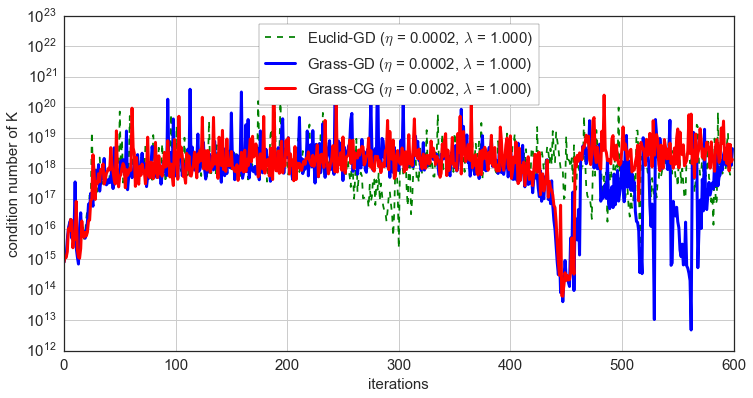

In [20]:
fig= plt.figure(1)
fig.set_size_inches(12.0, 6.0*len(lambda_array))
plt.style.use('seaborn-white')

for i in np.arange(len(lambda_array)):
    ax = plt.subplot(len(lambda_array),1,i+1)
    h1, = plt.semilogy(np.arange(max_iters), hist_condK_array[i], '--g')
    h2, = plt.semilogy(np.arange(max_iters), hist_condK_grass_array[i], '-b', linewidth=3.0)
    h3, = plt.semilogy(np.arange(max_iters), hist_condK_conjugate_array[i], '-r', linewidth=3.0)

    if add_reg:
         ax.legend([h1, h2, h3], [r"Euclid-GD ($\eta$ = {0:5.4f}, $\lambda$ = {1:5.3f})".format(eta, lambda_array[i]), \
                                  r"Grass-GD ($\eta$ = {0:5.4f}, $\lambda$ = {1:5.3f})".format(eta, lambda_array[i]), \
                                  r"Grass-CG ($\eta$ = {0:5.4f}, $\lambda$ = {1:5.3f})".format(eta, lambda_array[i])], \
                             fontsize = 15, loc='upper center', frameon=True)
        #ax.legend([h3], [r"Conjugate Grassmann ($\eta$ = {0:6.5f}, $\lambda$ = {1:5.3f})".format(eta, lambda_array[i])], \
        #                     fontsize = 15, loc='upper center', frameon=True)
    else:    
        ax.legend([h1, h2, h3], [r"Euclid-GD ($\eta$ = {0:6.5f})".format(eta), r"Grass-GD ($\eta$ = {0:6.5f})".format(eta), \
                                 r"Grass-CG ($\eta$ = {0:6.5f})".format(eta)], \
                             fontsize = 15, loc='upper center', frameon=True)
    plt.grid(1)
    plt.ylabel('condition number of K', fontsize = 15)
    plt.xlabel('iterations', fontsize = 15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
plt.show    
if Ifsavefig:
    file_org = "../figures/04_13_16_" + str(trial) + "_"
    file_tail = "_nll_iters_condK.eps"
    if choice == "random":
        file_comment = "rand"
    elif choice == "near":
        file_comment = "near"
        
    if add_reg:
        file_comment = file_comment +'Reg'
        
    fig.savefig(file_org + file_comment + file_tail )  

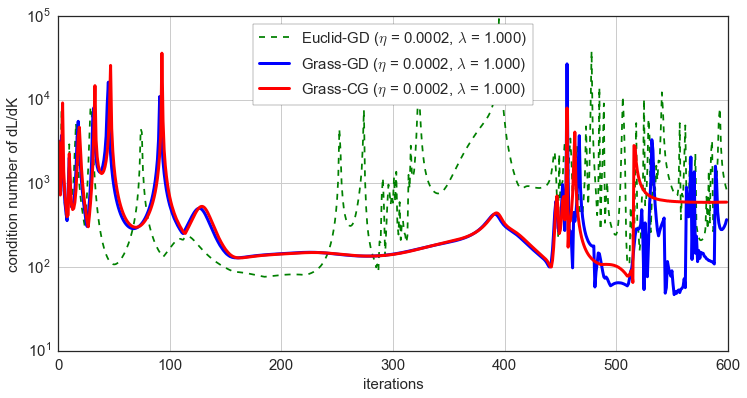

In [21]:
fig= plt.figure(1)
fig.set_size_inches(12.0, 6.0*len(lambda_array))
plt.style.use('seaborn-white')

for i in np.arange(len(lambda_array)):
    ax = plt.subplot(len(lambda_array),1,i+1)
    h1, = plt.semilogy(np.arange(max_iters), hist_cond2K_array[i], '--g')
    h2, = plt.semilogy(np.arange(max_iters), hist_cond2K_grass_array[i], '-b', linewidth=3.0)
    h3, = plt.semilogy(np.arange(max_iters), hist_cond2K_conjugate_array[i], '-r', linewidth=3.0)

    if add_reg:
         ax.legend([h1, h2, h3], [r"Euclid-GD ($\eta$ = {0:5.4f}, $\lambda$ = {1:5.3f})".format(eta, lambda_array[i]), \
                                  r"Grass-GD ($\eta$ = {0:5.4f}, $\lambda$ = {1:5.3f})".format(eta, lambda_array[i]), \
                                  r"Grass-CG ($\eta$ = {0:5.4f}, $\lambda$ = {1:5.3f})".format(eta, lambda_array[i])], \
                             fontsize = 15, loc='upper center', frameon=True)
        #ax.legend([h3], [r"Conjugate Grassmann ($\eta$ = {0:6.5f}, $\lambda$ = {1:5.3f})".format(eta, lambda_array[i])], \
        #                     fontsize = 15, loc='upper center', frameon=True)
    else:    
        ax.legend([h1, h2, h3], [r"Euclid-GD ($\eta$ = {0:6.5f})".format(eta), r"Grass-GD ($\eta$ = {0:6.5f})".format(eta), \
                                 r"Grass-CG ($\eta$ = {0:6.5f})".format(eta)], \
                             fontsize = 15, loc='upper center', frameon=True)
    plt.grid(1)
    plt.ylabel('condition number of dL/dK', fontsize = 15)
    plt.xlabel('iterations', fontsize = 15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
plt.show    
if Ifsavefig:
    file_org = "../figures/04_13_16_" + str(trial) + "_"
    file_tail = "_nll_iters_cond2K.eps"
    if choice == "random":
        file_comment = "rand"
    elif choice == "near":
        file_comment = "near"
        
    if add_reg:
        file_comment = file_comment +'Reg'
        
    fig.savefig(file_org + file_comment + file_tail )  

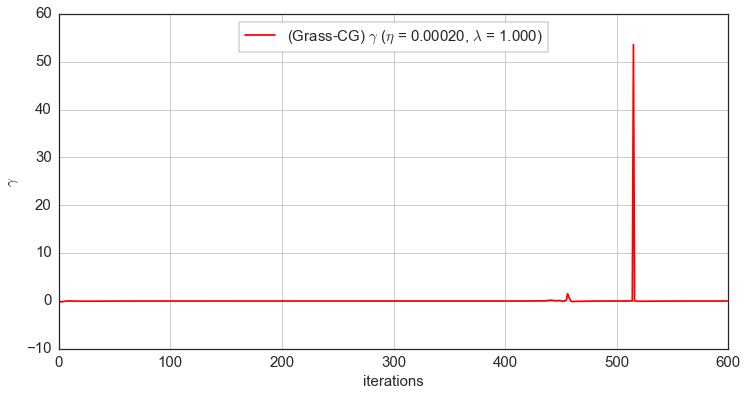

In [22]:
fig= plt.figure(5)
fig.set_size_inches(12.0, 6.0*len(lambda_array))
plt.style.use('seaborn-white')

for i in np.arange(len(lambda_array)):
    ax = plt.subplot(len(lambda_array),1,i+1)
    #h1, = plt.plot(np.arange(max_iters), hist_Gnorm_array[i], 'b')
    h1, = plt.plot(np.arange(max_iters), hist_gamma_array[i], 'r')
    if add_reg:
        ax.legend([h1], [r"(Grass-CG) $\gamma$ ($\eta$ = {0:6.5f}, $\lambda$ = {1:5.3f})".format(eta, lambda_array[i])], \
                             fontsize = 15, loc='upper center', frameon=True)
        #ax.legend([h1, h2], [r"(Grass-GD) G-norm ($\eta$ = {0:6.5f}, $\lambda$ = {1:5.3f})".format(eta, lambda_array[i]), \
        #                     r"(Grass-CG) G-norm ($\eta$ = {0:6.5f}, $\lambda$ = {1:5.3f})".format(eta, lambda_array[i])], \
        #                     fontsize = 15, loc='upper center', frameon=True)
    else:    
        ax.legend([h1, h2], [r"(Grass-GD) G-norm ($\eta$ = {0:6.5f})".format(eta), r"(Grass-CG) G-norm ($\eta$ = {0:5.4f})".format(eta)], \
                             fontsize = 15, loc='upper center', frameon=True)
    plt.grid(1)
    plt.ylabel(r"$\gamma$", fontsize = 15)
    plt.xlabel('iterations', fontsize = 15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
plt.show    
if Ifsavefig:
    file_org = "../figures/04_13_16_" + str(trial) + "_"
    file_tail = "_sig_iters_gamma_CG.eps"
    if choice == "random":
        file_comment = "rand"
    elif choice == "near":
        file_comment = "near"
        
    if add_reg:
        file_comment = file_comment +'Reg'
        
    fig.savefig(file_org + file_comment + file_tail )  

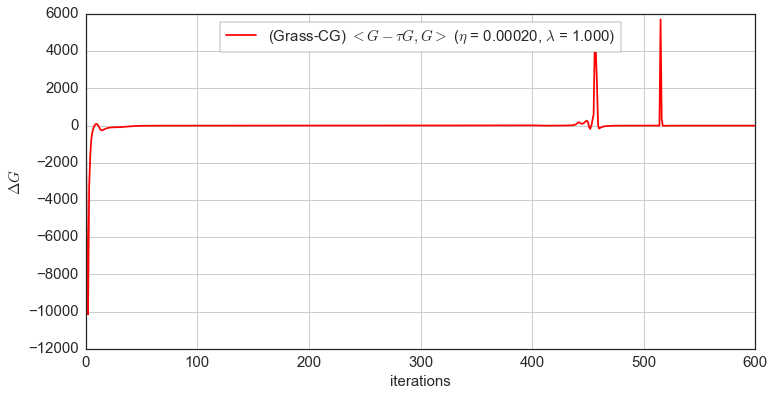

In [23]:
fig= plt.figure(6)
fig.set_size_inches(12.0, 6.0*len(lambda_array))
plt.style.use('seaborn-white')

for i in np.arange(len(lambda_array)):
    ax = plt.subplot(len(lambda_array),1,i+1)
    #h1, = plt.plot(np.arange(max_iters), hist_Gnorm_array[i], 'b')
    h1, = plt.plot(np.arange(max_iters), hist_deltaG_array[i], 'r')
    if add_reg:
        ax.legend([h1], [r"(Grass-CG) $<G - \tau G, G>$ ($\eta$ = {0:6.5f}, $\lambda$ = {1:5.3f})".format(eta, lambda_array[i])], \
                             fontsize = 15, loc='upper center', frameon=True)
        #ax.legend([h1, h2], [r"(Grass-GD) G-norm ($\eta$ = {0:6.5f}, $\lambda$ = {1:5.3f})".format(eta, lambda_array[i]), \
        #                     r"(Grass-CG) G-norm ($\eta$ = {0:6.5f}, $\lambda$ = {1:5.3f})".format(eta, lambda_array[i])], \
        #                     fontsize = 15, loc='upper center', frameon=True)
    else:    
        ax.legend([h1, h2], [r"(Grass-GD) G-norm ($\eta$ = {0:6.5f})".format(eta), r"(Grass-CG) G-norm ($\eta$ = {0:5.4f})".format(eta)], \
                             fontsize = 15, loc='upper center', frameon=True)
    plt.grid(1)
    plt.ylabel(r"$\Delta G$", fontsize = 15)
    plt.xlabel('iterations', fontsize = 15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
plt.show    
if Ifsavefig:
    file_org = "../figures/04_13_16_" + str(trial) + "_"
    file_tail = "_sig_iters_dG_CG.eps"
    if choice == "random":
        file_comment = "rand"
    elif choice == "near":
        file_comment = "near"
        
    if add_reg:
        file_comment = file_comment +'Reg'
        
    fig.savefig(file_org + file_comment + file_tail )  

In [24]:
hist_deltaG_array[1]

IndexError: list index out of range